## Load the dataset

In [1]:
import numpy as np
import keras
from keras import layers


def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

n_classes = len(np.unique(y_train))

idx = np.random.permutation(len(x_train))
x_train = x_train[idx]
y_train = y_train[idx]

y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

2023-12-06 10:57:22.696818: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-06 10:57:22.726187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 10:57:22.726224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 10:57:22.727203: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 10:57:22.732754: I tensorflow/core/platform/cpu_feature_guar

In [1]:
# Check if we are using GPU
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
else:
    print("Not using GPU")

2023-12-08 12:14:02.080123: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-08 12:14:02.746222: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-08 12:14:02.746282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-08 12:14:02.849716: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-08 12:14:03.057116: I tensorflow/core/platform/cpu_feature_guar

Using GPU


2023-12-08 12:14:05.546268: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 12:14:05.795294: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 12:14:05.795350: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

2023-12-08 12:15:44.718269: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 12:15:44.718348: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 12:15:44.718361: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 12:15:44.893435: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-08 12:15:44.893512: I external/local_xla/xla/stream_executor

'/device:GPU:0'

## Build the model

In [5]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Attention and Normalization
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res



In [6]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)
    return keras.Model(inputs, outputs)

## Train and evaluate

In [7]:
input_shape = x_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["sparse_categorical_accuracy"],
)
model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=150,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(x_test, y_test, verbose=1)

2023-12-06 10:57:44.501752: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 10:57:44.501829: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 10:57:44.501839: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 10:57:44.502118: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-06 10:57:44.502133: I tensorflow/core/common_runtime/gpu/gpu

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 1)]             0         []                            
                                                                                                  
 multi_head_attention (Mult  (None, 500, 1)               7169      ['input_1[0][0]',             
 iHeadAttention)                                                     'input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 500, 1)               0         ['multi_head_attention[0][0]']
                                                                                                  
 layer_normalization (Layer  (None, 500, 1)               2         ['dropout[0][0]']         

2023-12-06 10:57:54.523728: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2023-12-06 10:57:54.886167: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8a7467f710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-06 10:57:54.886241: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2023-12-06 10:57:54.890345: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701860274.948493    5412 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2023-12-06 10:58:05.703120: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 125.00MiB (rounded to 131072000)requested by op g

ResourceExhaustedError: Graph execution error:

Detected at node gradient_tape/model/multi_head_attention_3/einsum_1/Einsum_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/ipykernel_launcher.py", line 17, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 739, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 604, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 529, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 518, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 424, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 766, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/tmp/ipykernel_5332/2986740648.py", line 23, in <module>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py", line 1154, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/optimizer.py", line 543, in minimize

  File "/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients

OOM when allocating tensor with shape[64,4,256,500] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/model/multi_head_attention_3/einsum_1/Einsum_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_8598]

## Linear model with keras


In [12]:
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.optimizers import Adam, SGD
# from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
# from sklearn.datasets import make_circles, make_regression, load_digits
from keras.datasets.mnist import load_data
from keras.datasets import fashion_mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import requests
from pathlib import Path
from livelossplot import PlotLossesKeras
# from sklearn.neural_network import MLPClassifier
# Create an early stopping
from keras.callbacks import EarlyStopping
from keras.utils import plot_model, to_categorical

In [545]:
# Download the helper function
if Path("course_ztm.py").is_file():
    print("course_ztm.py already exists, skipping download")
else:
    print("Downloading course_ztm.py")
    request = requests.get("https://raw.githubusercontent.com/JoachimLombardi/Helper_functions/master/course_ztm.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

In [546]:
def plot_decision_boundary(model, X, y):
  """
  Plot decision boundary created by a model predicting on X.
  This function was inspired by two resources:
  1. https://cs231n.github.io/neural-networks-case-study/
  2. https://github.com/GokuMohandas/Made-With-ML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),  # Mesh grid va créer deux matrices l'une avec les x horizontalement, l'autre avec les y verticalement
                       np.linspace(y_min, y_max, 100))  # e.g x = [1,2] => [1,2], [1,2] et y = [5,6] => [5,5], [6,6]

  # Create X_values (we're going to make predictions on this)
  x_in = np.c_[xx.ravel(), yy.ravel()] # Stack 2D arrays together, ravel() puts matrix components in one. e.g [1, 2], [1,2] => [1,2,1,2] et [5,5], [6,6] => [5,5,6,6]
                                       # c_[] donne la transposé des ligne ci-dessus [1, 5],[2,5],[1,6],[2,6]
  # Make predictions
  y_pred = model.predict(x_in)

  # Check for multi-class
  if len(y_pred[0].reshape(-1,1)) > 1:
    print("doing multiclass classification")
    # We have to reshape our prediction to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classification")
    y_pred = np.round(y_pred).reshape(xx.shape) # Le resultat est remis en matrice de la forme

  # Plot the decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7) # alpha is the brightness, plot the background
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max()) # lim of x
  plt.ylim(yy.min(), yy.max())

In [583]:
# Create a dataset with noise
X, y = make_regression(n_samples=100, n_features=1, noise=10, random_state=42)

In [584]:
X[:3]

array([[ 0.93128012],
       [ 0.08704707],
       [-1.05771093]])

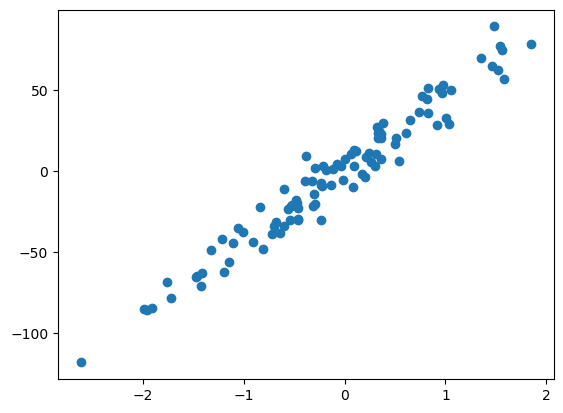

In [585]:
plt.scatter(X, y)

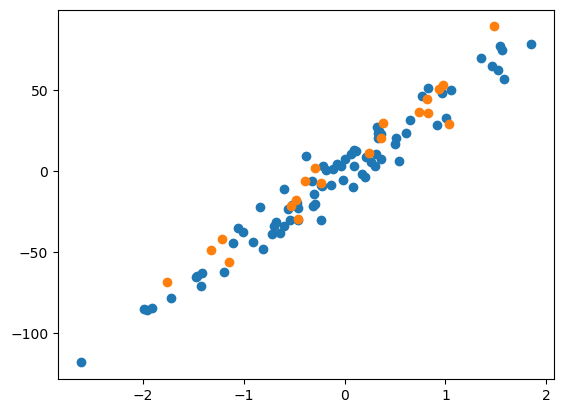

In [586]:
# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Plot the data
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test)

In [587]:
# Build the model with sklearn
model = RandomForestRegressor()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mean_squared_error(y_test, y_pred)

150.88422879790556

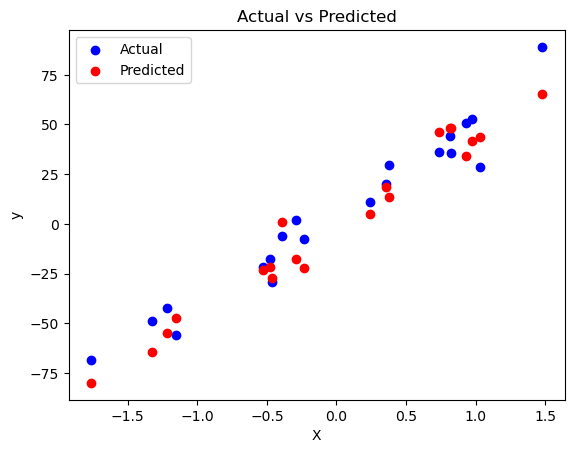

In [588]:
# Plot the results
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [589]:
# Same with keras

# Build the model
model = Sequential()

# Add layers
model.add(Dense(1))

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.1), 
              loss='mse',
              metrics=['mean_squared_error'])

# Fit the model
hist = model.fit(X_train, 
          y_train, 
          epochs=100,
          validation_data=(X_test, y_test))

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
model.evaluate(X_test, y_test)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1389.7507 - mean_squared_error: 1389.7507 - val_loss: 675.0259 - val_mean_squared_error: 675.0259
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 526.5172 - mean_squared_error: 526.5172 - val_loss: 335.5528 - val_mean_squared_error: 335.5528
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 236.4057 - mean_squared_error: 236.4057 - val_loss: 195.9430 - val_mean_squared_error: 195.9430
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 131.2180 - mean_squared_error: 131.2180 - val_loss: 142.1218 - val_mean_squared_error: 142.1218
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 86.6978 - mean_squared_error: 86.6978 - val_loss: 123.4814 - val_mean_squared_error: 123.4814
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 76.7543 - mean_squared_error: 76.7543 - val_loss: 109.6296 - val_mean_squared_error: 109.6296
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 74.3806 - mean_squared_err

[104.4151382446289, 104.4151382446289]

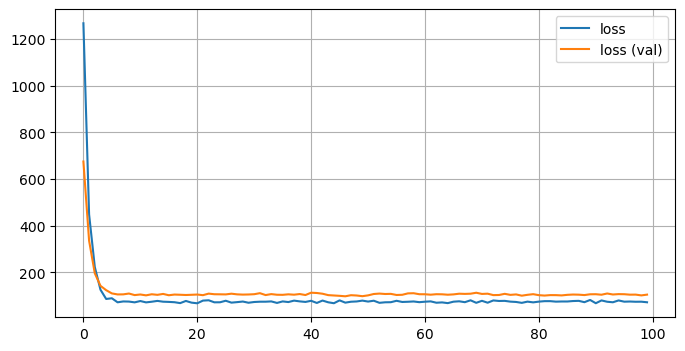

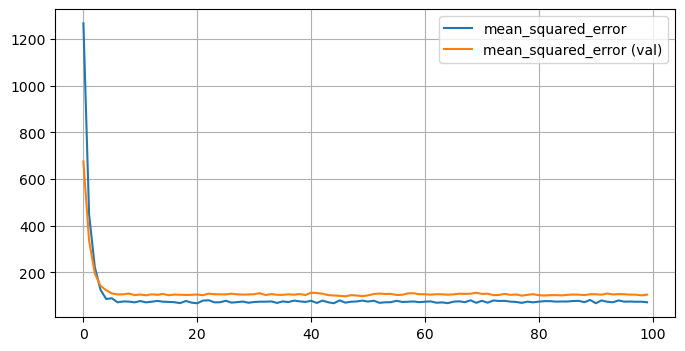

In [590]:
hist.history.keys()

plt.figure(figsize=(8,4))
plt.plot(hist.history["loss"],label="loss")
plt.plot(hist.history["val_loss"],label="loss (val)")
plt.grid()
plt.legend()

plt.figure(figsize=(8,4))
plt.plot(hist.history["mean_squared_error"],label="mean_squared_error")
plt.plot(hist.history["val_mean_squared_error"],label="mean_squared_error (val)")
plt.grid()

plt.legend()

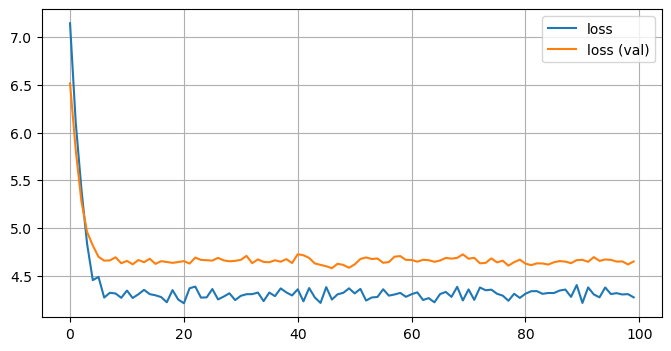

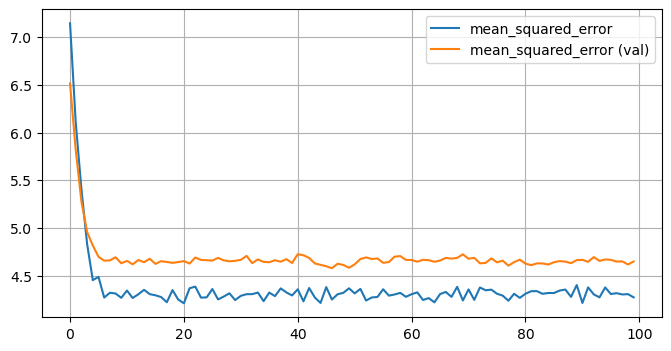

In [591]:
plt.figure(figsize=(8,4))
plt.plot(np.log(hist.history["loss"]),label="loss")
plt.plot(np.log(hist.history["val_loss"]),label="loss (val)")
plt.grid()
plt.legend()

plt.figure(figsize=(8,4))
plt.plot(np.log(hist.history["mean_squared_error"]),label="mean_squared_error")
plt.plot(np.log(hist.history["val_mean_squared_error"]),label="mean_squared_error (val)")
plt.grid()
plt.legend()

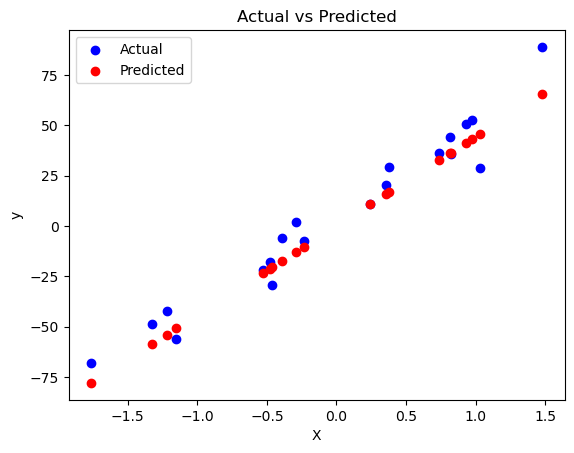

In [592]:
# Plot the results
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.scatter(X_test, y_pred, color='red', label='Predicted')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [593]:
X, y = make_circles(n_samples=500, noise=0.05, random_state=42)
print(X.shape)

(500, 2)


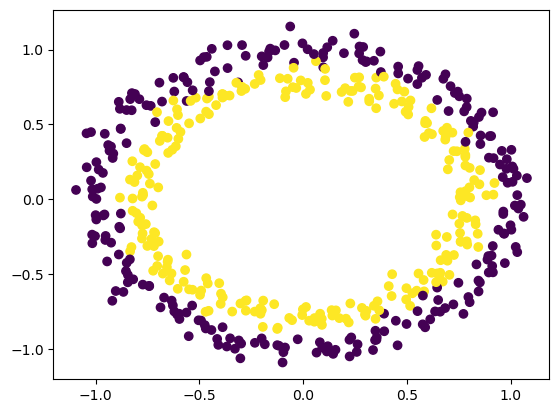

In [594]:
# Plot
plt.scatter(X[:, 0], X[:, 1], c=y)

In [595]:
np.unique(y, return_counts=True)

(array([0, 1], dtype=int64), array([250, 250], dtype=int64))

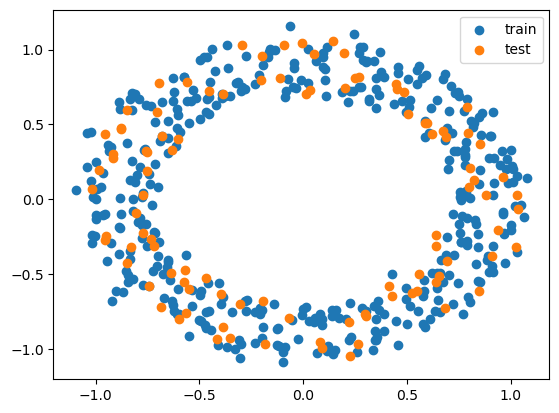

In [596]:
# Create train and test splits
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Plot the data
plt.scatter(X_train[:, 0], X_train[:, 1])
plt.scatter(X_test[:, 0], X_test[:, 1])
plt.legend(['train', 'test'])

In [597]:
X_train[0], y_train[0]

(array([-0.50397764, -0.80980415]), 0)

In [598]:
# Build the model with sklearn
model = RandomForestClassifier()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = np.round(model.predict(X_test))

# Evaluate the model
accuracy_score(y_test, y_pred)

0.95

doing binary classification


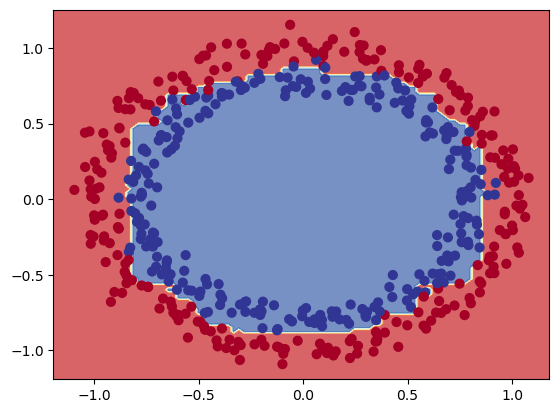

In [599]:
# Plot the results
plot_decision_boundary(model, X, y)

In [600]:
# Same with keras

# Build the model
model = Sequential()

# Add layers
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=SGD(), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Fit the model
histcl = model.fit(X_train, 
          y_train, 
          epochs=100,
          validation_data=(X_test, y_test))

# Make predictions
y_pred = np.round(model.predict(X_test))

# Evaluate the model
model.evaluate(X_test, y_test)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4841 - loss: 0.8314 - val_accuracy: 0.4922 - val_loss: 0.8732
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5051 - loss: 0.7999 - val_accuracy: 0.4922 - val_loss: 0.8699
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4864 - loss: 0.8146 - val_accuracy: 0.4922 - val_loss: 0.8669
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4837 - loss: 0.8284 - val_accuracy: 0.4922 - val_loss: 0.8638
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5176 - loss: 0.7803 - val_accuracy: 0.4922 - val_loss: 0.8608
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4562 - loss: 0.8340 - val_accuracy: 0.4844 - val_loss: 0.8576
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5280 - loss: 0.7876 - val_accuracy: 0.4844 - val_loss: 0.8545
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4706 - loss: 0.8381 - val_accuracy: 0.4844 - v

[0.7260571718215942, 0.4765625]

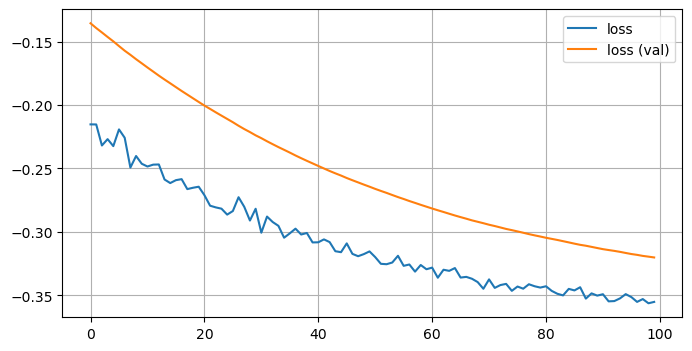

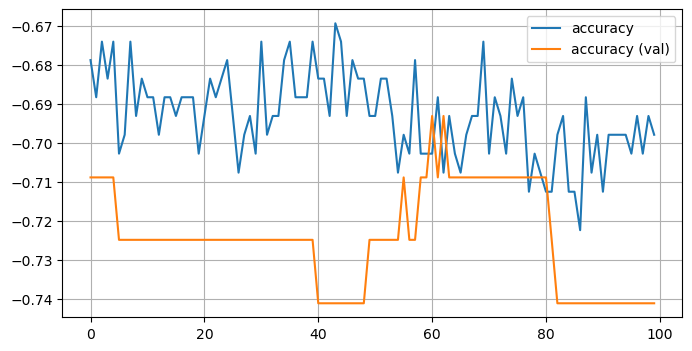

In [601]:
plt.figure(figsize=(8,4))
plt.plot(np.log(histcl.history["loss"]),label="loss")
plt.plot(np.log(histcl.history["val_loss"]),label="loss (val)")
plt.grid()
plt.legend()

plt.figure(figsize=(8,4))
plt.plot(np.log(histcl.history["accuracy"]),label="accuracy")
plt.plot(np.log(histcl.history["val_accuracy"]),label="accuracy (val)")
plt.grid()
plt.legend()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 369us/step
doing binary classification


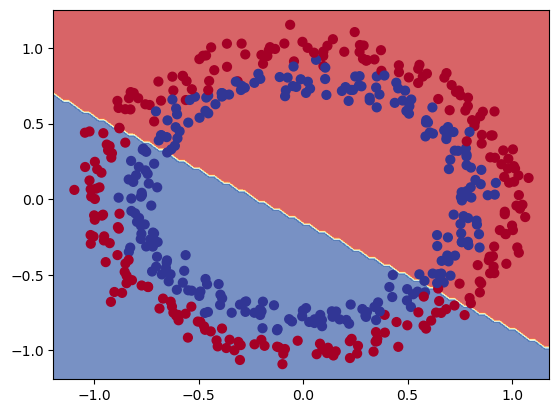

In [602]:
# Plot the results
plot_decision_boundary(model, X, y)

In [36]:
digits = load_data()

In [37]:
# Make a train/test split
(X_train, y_train), (X_test, y_test) = load_data()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [38]:
X_train.shape

(60000, 28, 28)

In [39]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [9]:
plot_losses = PlotLossesKeras()

NameError: name 'PlotLossesKeras' is not defined

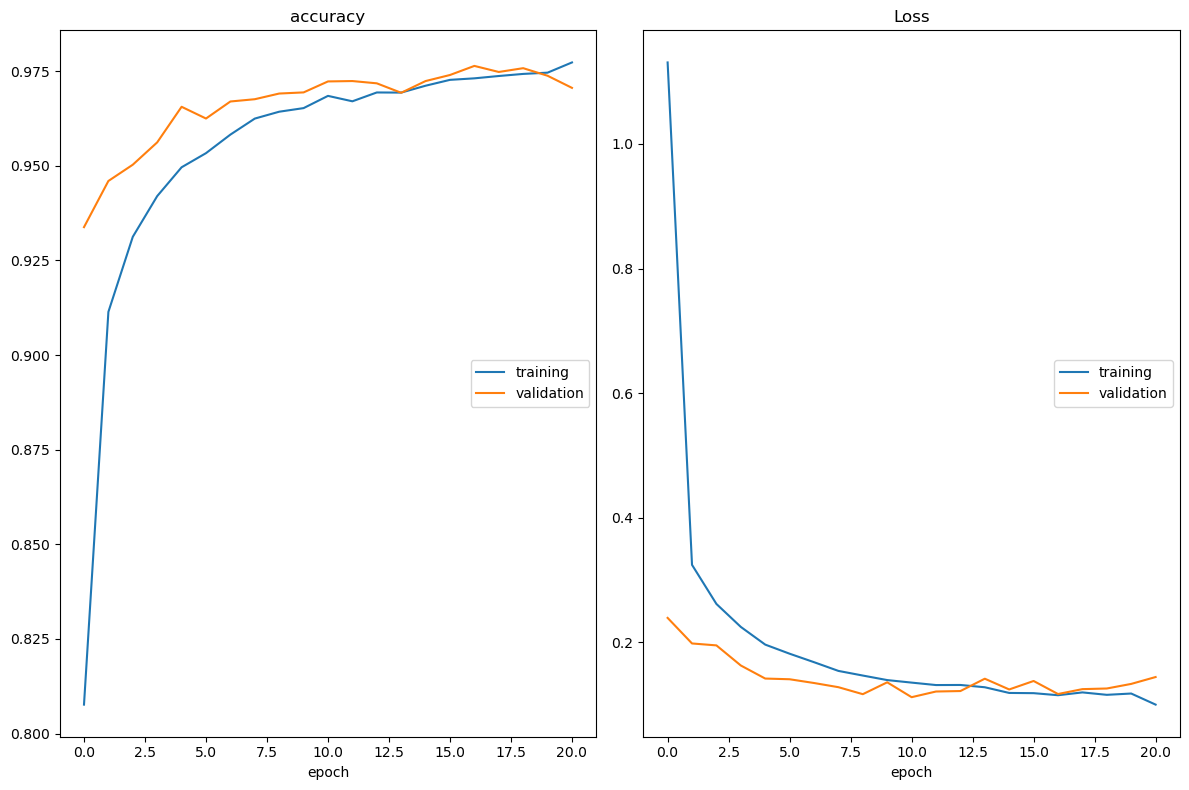

accuracy
	training         	 (min:    0.808, max:    0.977, cur:    0.977)
	validation       	 (min:    0.934, max:    0.976, cur:    0.971)
Loss
	training         	 (min:    0.100, max:    1.131, cur:    0.100)
	validation       	 (min:    0.112, max:    0.239, cur:    0.144)
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9780 - loss: 0.0944 - val_accuracy: 0.9706 - val_loss: 0.1445
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [41]:
# Avec le perceptron	
model = Sequential([
    Flatten(input_shape=(28,28)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X_train, 
                 y_train, 
                 epochs=200,
                 validation_data=(X_test, y_test),
                 batch_size=32,
                 callbacks=[plot_losses, EarlyStopping(monitor='val_loss', patience=10)])

y_pred = np.argmax(model.predict(X_test), axis=1)
accuracy_score(y_test, y_pred)

# classification_report
report = classification_report(y_test, y_pred)

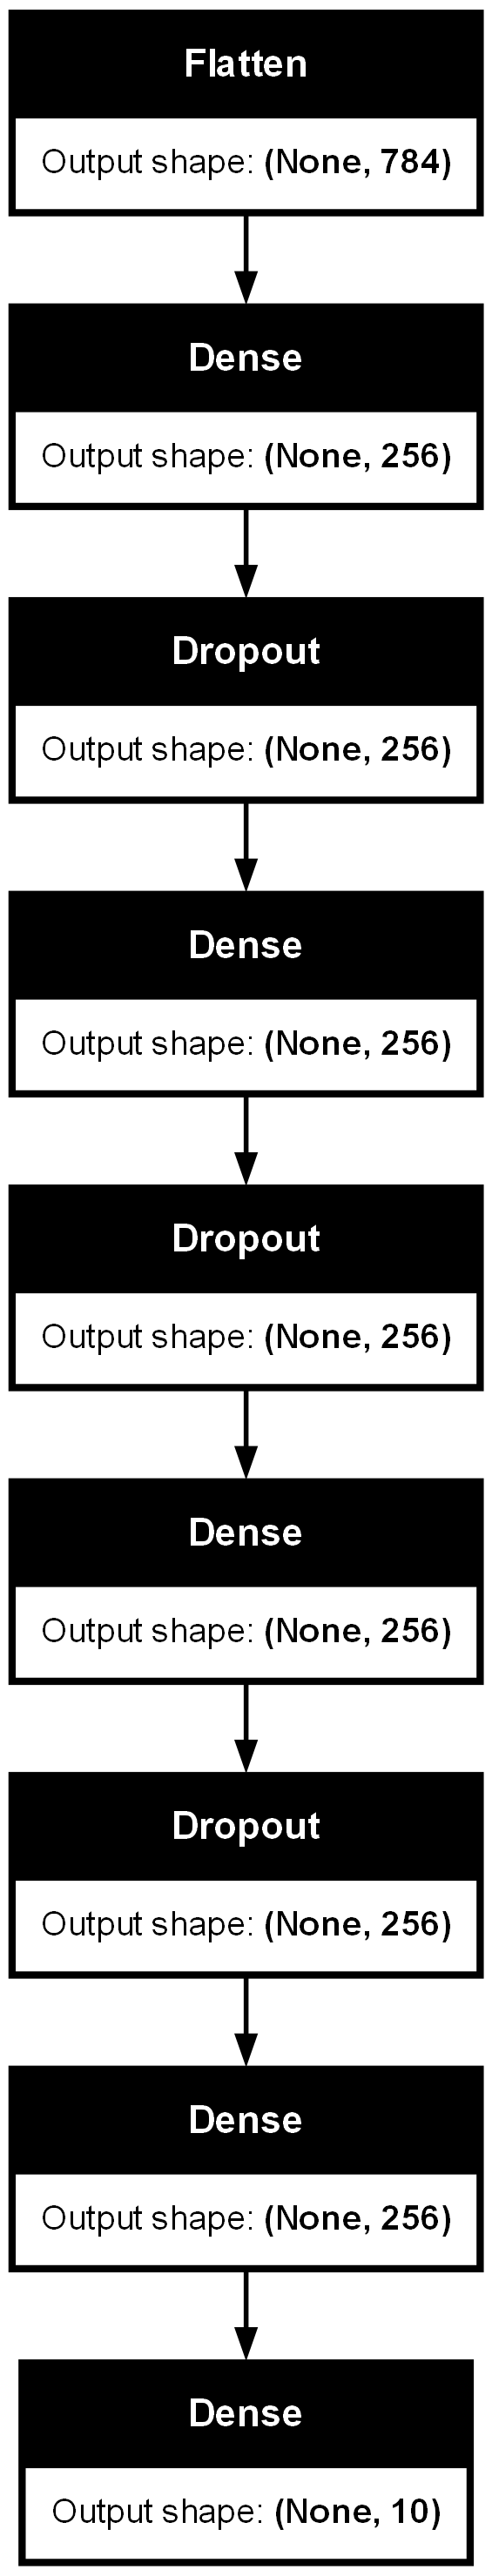

In [42]:
plot_model(model, show_shapes=True)

In [43]:
print(report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       980
           1       1.00      0.98      0.99      1135
           2       0.98      0.97      0.98      1032
           3       0.97      0.98      0.98      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.97      0.97       892
           6       0.97      0.98      0.97       958
           7       0.92      0.99      0.96      1028
           8       0.95      0.96      0.95       974
           9       0.98      0.93      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



In [9]:
def plot_images(X_test, y_pred, y_test, classe = None):
    # Plot some numbers
    plt.figure(figsize=(20, 15))
    # Take five random images
    random_number = np.random.randint(0, len(X_test))
    for index, (image, prediction, label) in enumerate(zip(X_test[random_number:random_number+10], y_pred[random_number:random_number+10], y_test[random_number:random_number+10])):
        plt.subplot(2, 5, index + 1)
        plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
        if (prediction == label):
            if classe:
                plt.title(f'Predictions: {classe[prediction]}\n True: {classe[label]}',  fontsize = 20, color = 'green')
            else:
                plt.title(f'Predictions: {prediction}\n True: {label}',  fontsize = 20, color = 'green')
        else:
            if classe:
                plt.title(f'Predictions: {classe[prediction]}\n True: {classe[label]}',  fontsize = 20, color = 'red')
            else:
                plt.title(f'Predictions: {prediction}\n True: {label}',  fontsize = 20, color = 'red')
        plt.axis('off')

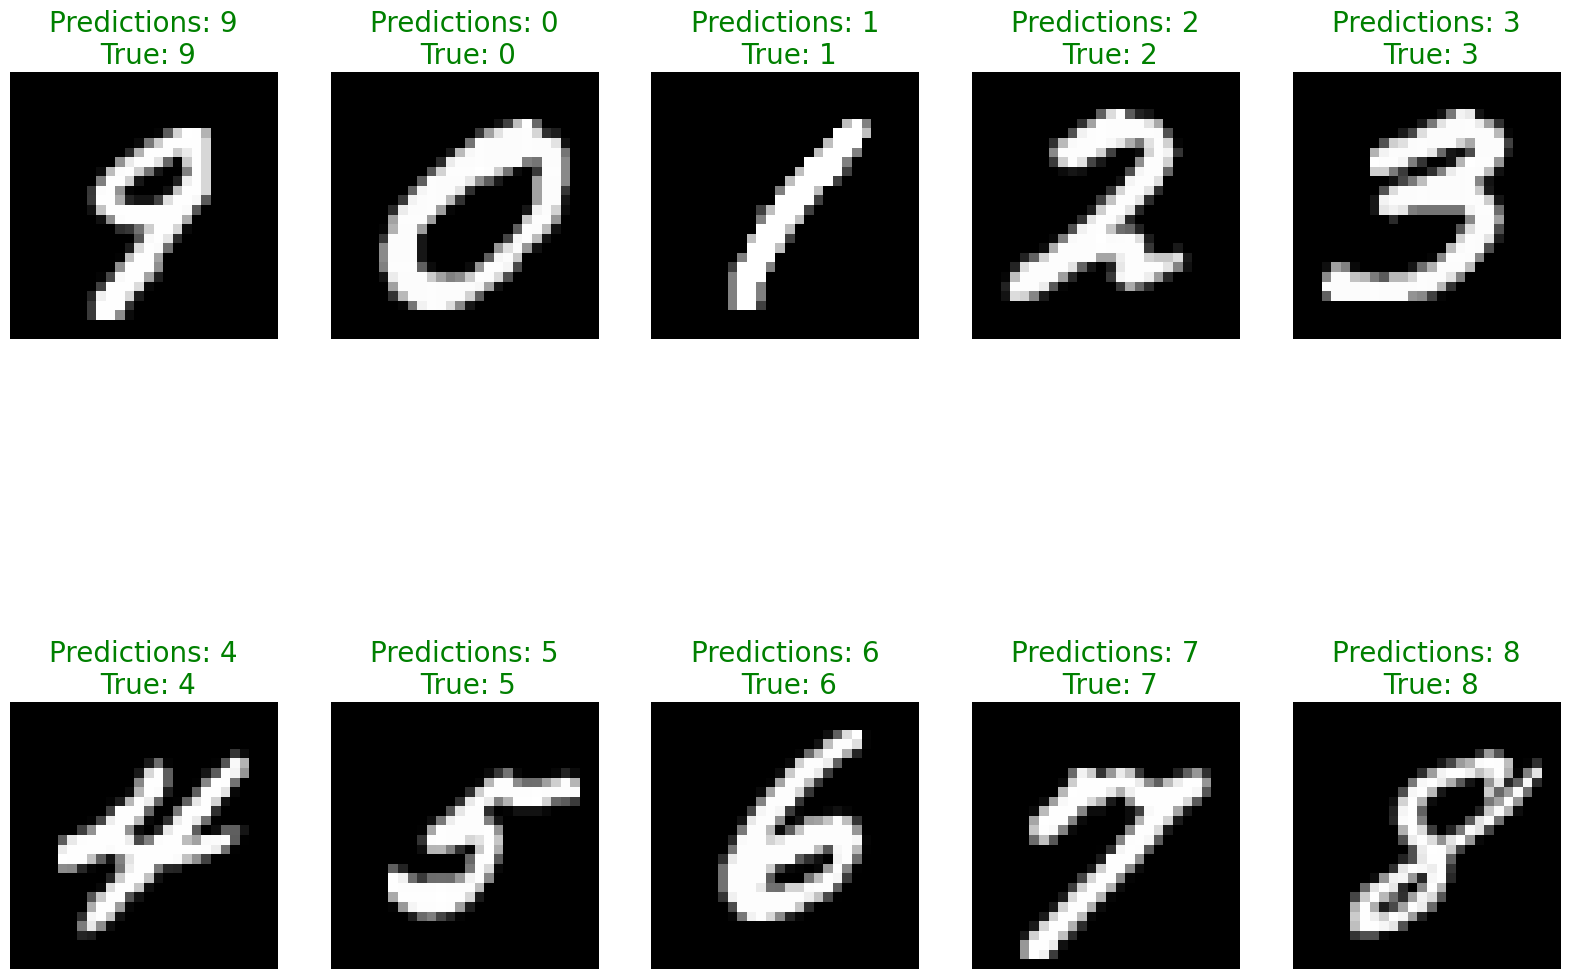

In [45]:
plot_images(X_test, y_pred, y_test)

In [46]:
X_train = X_train.reshape(X_train.shape[0], -1) # -1 means that the dimension is inferred
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape

(60000, 784)

In [47]:
model_cl = MLPClassifier(max_iter=1000)
model_cl.fit(X_train, y_train)
y_pred_cl = model_cl.predict(X_test)
accuracy_score(y_test, y_pred)

0.9706

In [48]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_8 (Dense)                 │ (None, 256)               │    200,960 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_3 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_9 (Dense)                 │ (None, 256)               │     65,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_4 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_10 (Dense)                │ (None, 256)               │     65,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_5 (Dropout)             │ (None, 256)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_11 (Dense)                │ (None, 256)               │     65,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_12 (Dense)                │ (None, 10)                │      2,570 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 1,202,720 (4.59 MB)

 Trainable params: 400,906 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 801,814 (3.06 MB)

## Convolutional Neural Network

In [21]:
(X_train, y_train), (X_test, y_test) = load_data()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [22]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

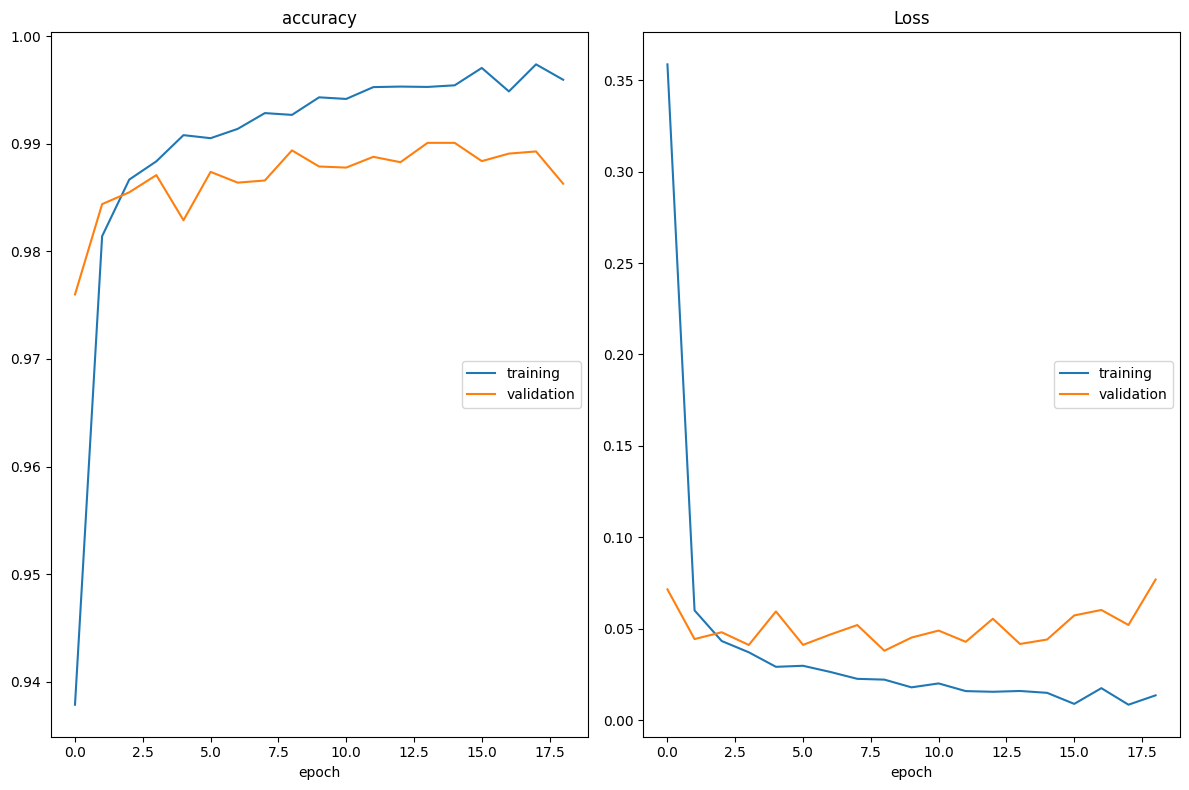

accuracy
	training         	 (min:    0.938, max:    0.997, cur:    0.996)
	validation       	 (min:    0.976, max:    0.990, cur:    0.986)
Loss
	training         	 (min:    0.008, max:    0.359, cur:    0.014)
	validation       	 (min:    0.038, max:    0.077, cur:    0.077)
313/313 [==============================] - 0s 1ms/step


In [23]:
model_conv = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model_conv.compile(optimizer=Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_conv.summary()


hist = model_conv.fit(X_train, 
               y_train, 
               epochs=100, 
               validation_data=(X_test, y_test),
               batch_size=64,
               callbacks=[EarlyStopping(monitor='val_loss', patience=10), PlotLossesKeras()])

y_pred = model_conv.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)



In [24]:
model_conv.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 64)          36928     
                                                                 
 flatten_4 (Flatten)         (None, 3136)             

In [25]:
y_test = np.argmax(y_test, axis=1)
y_test.shape

(10000,)

In [26]:
print(accuracy_score(y_test, y_pred))
report = classification_report(y_test, y_pred)
print(report)

NameError: name 'accuracy_score' is not defined

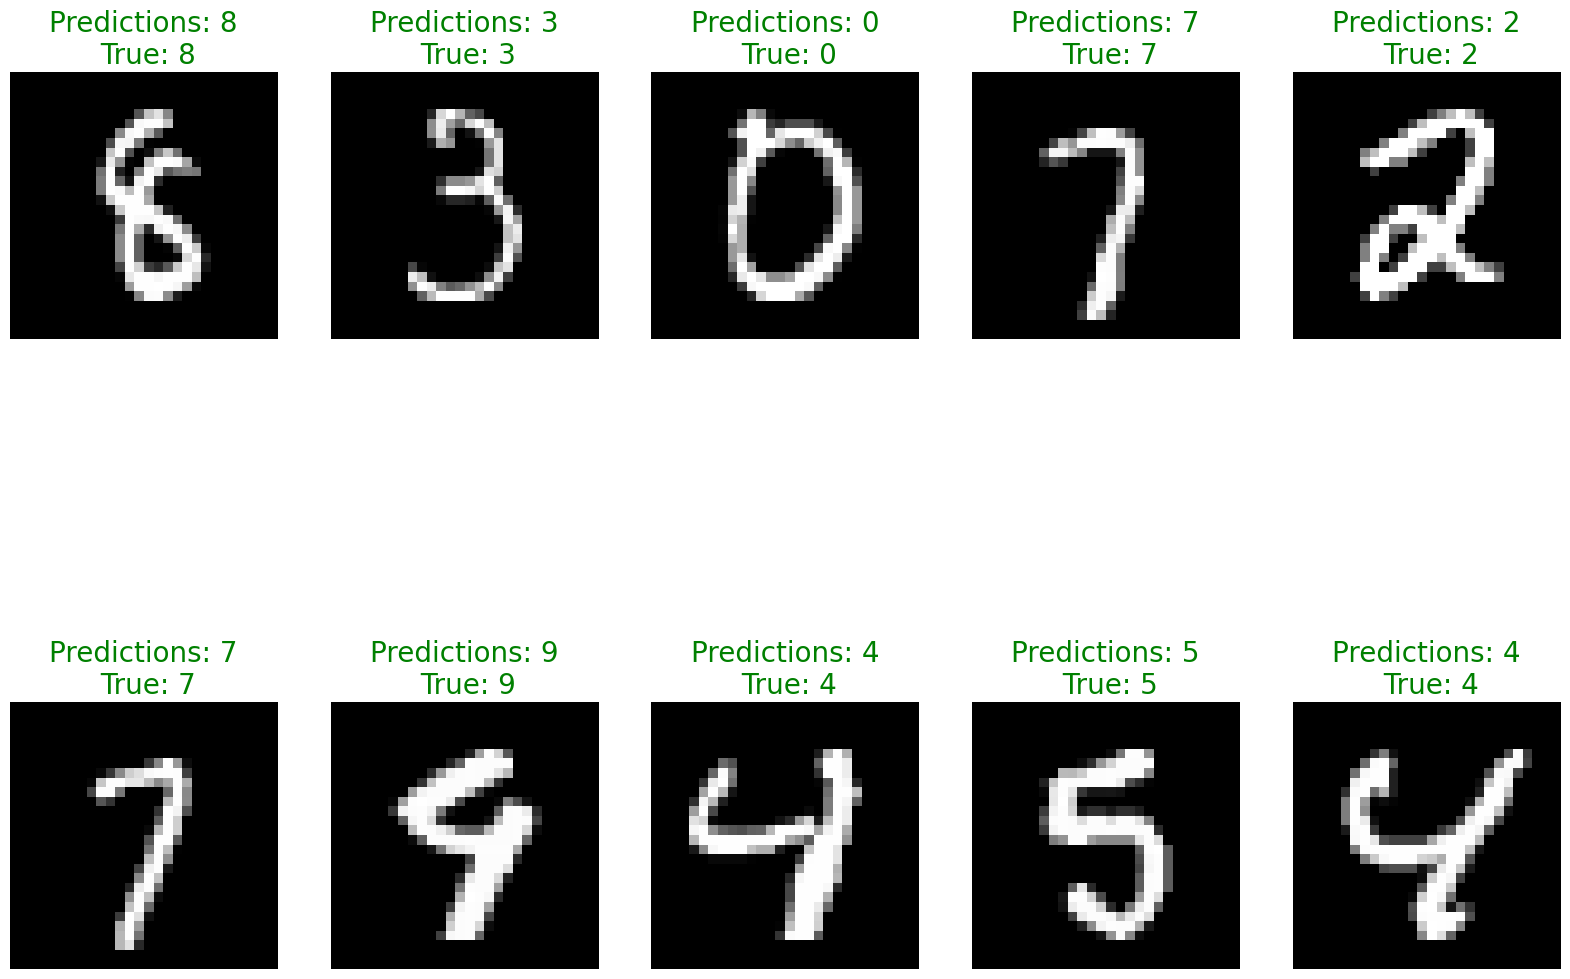

In [ ]:
plot_images(X_test, y_pred, y_test)

In [ ]:
# inp = model_conv
# index=10
# out = model_conv.layers[1].output
# feature_model = Model(inputs=inp, outputs=out)

# example_image = X_test[index].reshape(1, 28, 28, 1)
# activation = feature_model.predict(example_image)

In [ ]:
# plt.figure(figsize=(16,16))
# for n in range(32):
#     plt.subplot(8,4,n+1)
#     plt.imshow(activation[0,:,:,n],cmap="gray")
#     plt.axis(False)

## Fashion Minst Dataset

In [ ]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train.shape, X_test.shape, y_train.shape, y_test.shape

4422102/4422102 [==============================] - 4s 1us/step


((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [ ]:
X_train, X_test = X_train/255., X_test/255.

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

In [ ]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_test

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

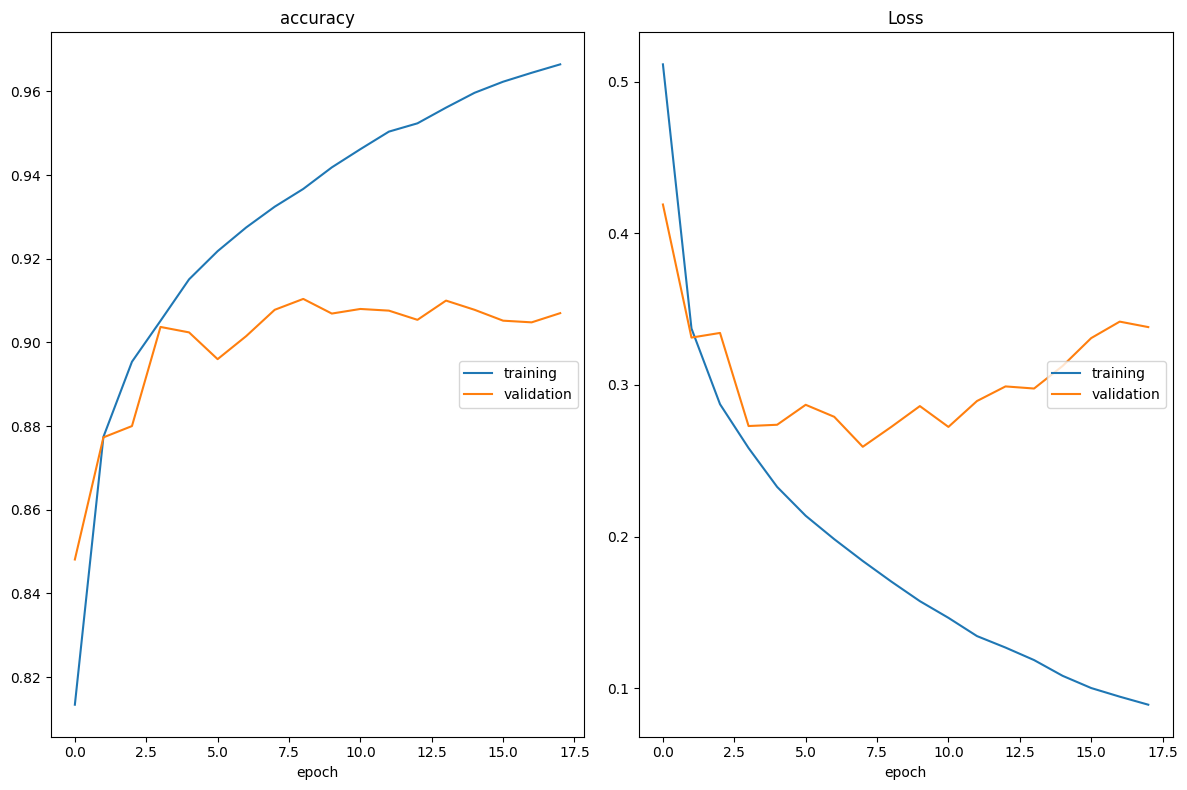

accuracy
	training         	 (min:    0.813, max:    0.966, cur:    0.966)
	validation       	 (min:    0.848, max:    0.910, cur:    0.907)
Loss
	training         	 (min:    0.089, max:    0.511, cur:    0.089)
	validation       	 (min:    0.259, max:    0.419, cur:    0.338)
313/313 [==============================] - 0s 1ms/step


In [ ]:
# Build the model

model_conv = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(10, activation='softmax'),
])

model_conv.compile(optimizer=Adam(),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

model_conv.summary()

hist = model_conv.fit(X_train, 
                      y_train, 
                      epochs=100, 
                      validation_data=(X_test, y_test),
                      batch_size=32,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=10), PlotLossesKeras()])

y_pred = model_conv.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
y_test = np.argmax(y_test, axis=1)
y_test.shape

(10000,)

In [ ]:
print(accuracy_score(y_test, y_pred))
report = classification_report(y_test, y_pred)
print(report)

NameError: name 'accuracy_score' is not defined

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

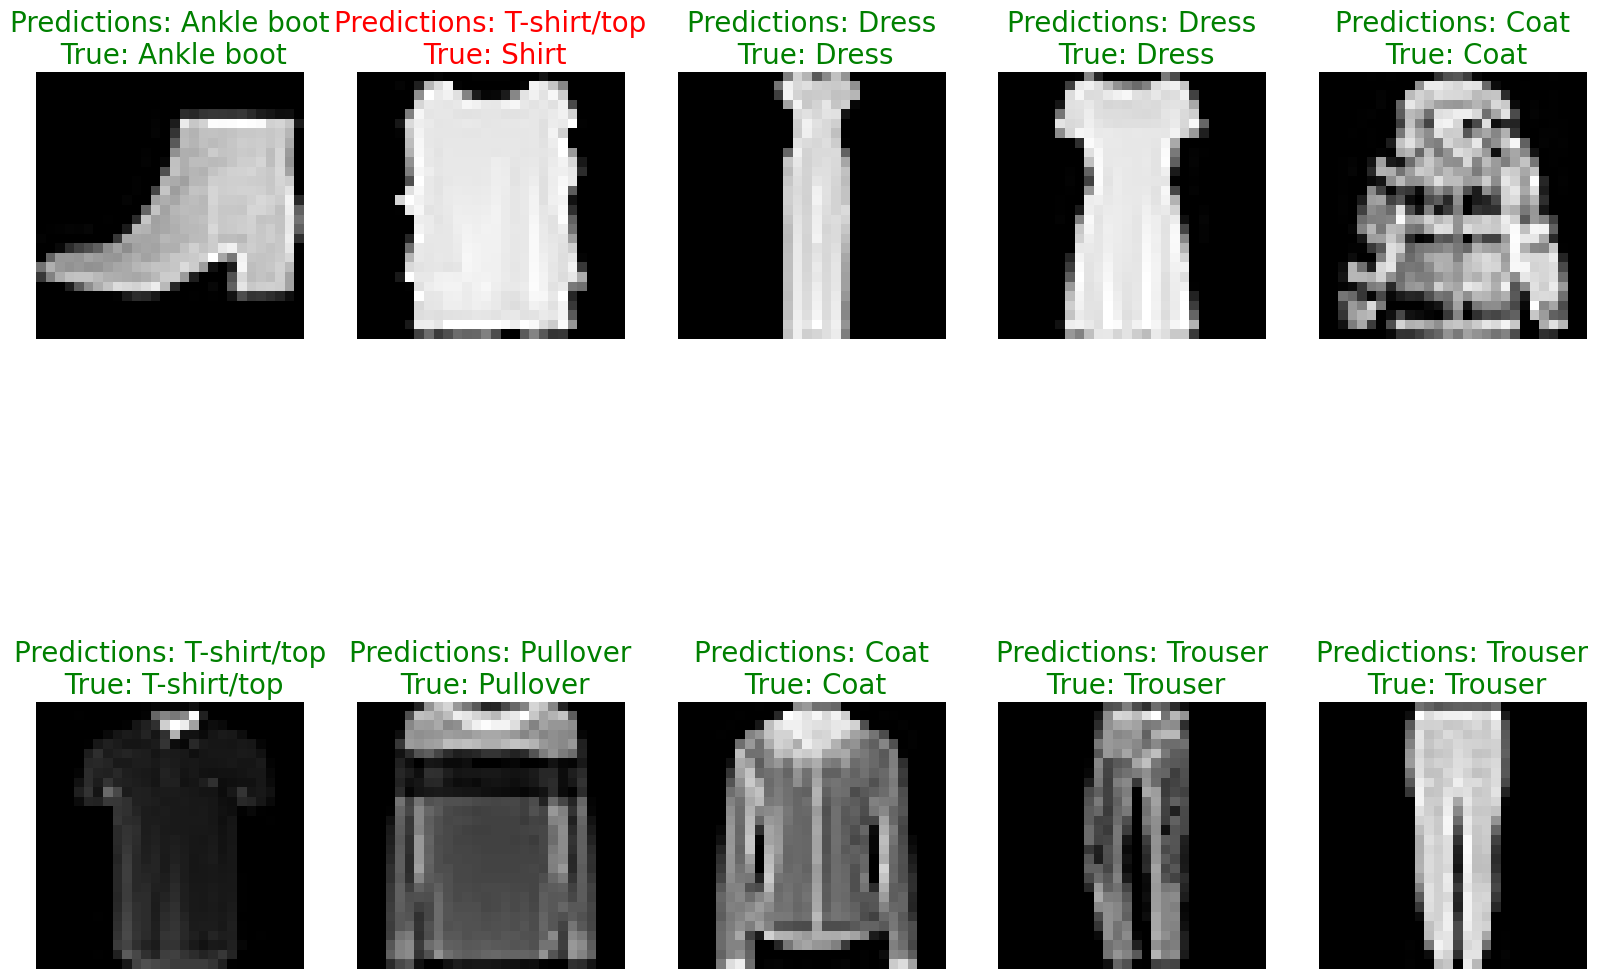

In [ ]:
plot_images(X_test, y_pred, y_test, classe = class_names)